In [1]:
import dill
import pandas as pd
import gc
import joblib
import re
import time
import pickle

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

from xgboost.sklearn import XGBClassifier

from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE

from custtransformer import *

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier


In [7]:
import lightgbm 
print (lightgbm.__version__)

from platform import python_version
print (python_version())

3.2.1
3.7.13


In [40]:
import lightgbm as lgb

In [19]:
with open('../data/cleaned/dict_cleaned.pkl', 'rb') as file:
    dict_df = dill.load(file)

X_train_base = dict_df['X_train']
y_train_base = dict_df['y_train']
X_test_base = dict_df['X_test']

In [20]:
# ratio of target=1 to target=0
RATIO_1_TO_0 = 0.08781828601345662

# X y DataFrame manipuation functions

In [21]:
def init_results():
    global results 
    results = pd.DataFrame(columns=[
        'classifier',
        'auc_score',
        'best_score',
        'classification_report',
        'params',
        'fit_time',
        'predict_time'
        ])

def add_result(classifier,auc_score,best_score,classification_report,params,fit_time,predict_time):
    global results
    new_row = { 'classifier':classifier, 
                'auc_score':auc_score, 
                'best_score':best_score,
                'classification_report': classification_report,
                'params':params,
                'fit_time':fit_time,
                'predict_time':predict_time
                }
    results = results.append(new_row, ignore_index=True)

def show_results_full():
    global results
    for idx,row in results.iterrows():
        print (row['classifier'])
        print ('AUC SCORE:   ',row['auc_score'])
        print ('BEST SCORE:  ',row['best_score'])
        print ('BEST PARAMS: ',row['params'])
        print ('FIT TIME:    ',row['fit_time'])
        print ('PREDICT TIME:',row['predict_time'])
        print (row['classification_report'])
        print ()
        print ()

def show_results_basic():
    global results
    return results[['classifier','auc_score','best_score','fit_time','predict_time']].sort_values('auc_score', ascending=False)

In [22]:
def make_full_df(X_train, y_train):
    dfT = X_train
    dfT = pd.get_dummies(dfT, columns=dfT.select_dtypes(include='object').columns)
    dfT = dfT.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    dfT['TARGET'] = y_train
    return dfT

def get_Xy_full(df):
    X = df.drop(columns=['TARGET'])
    y = df.TARGET
    return X, y

def get_Xy_sample_df(df,num_records,target_ratio):
    num_target_0 = int(round(num_records * target_ratio,0))
    num_target_1 = int(round(num_records - num_target_0))
    df_1 = df[df.TARGET == 1].sample(n=num_target_1)
    df_0 = df[df.TARGET == 0].sample(n=num_target_0)
    df_full = pd.concat([df_1,df_0])
    X = df_full.drop(columns=['TARGET'])
    y = df_full.TARGET
    return X,y

def get_Xy_sample_base(X_train, y_train,num_records,target_ratio):
    num_target_0 = int(round(num_records * target_ratio,0))
    num_target_1 = int(round(num_records - num_target_0))
    df = make_full_df(X_train, y_train)
    df_1 = df[df.TARGET == 1].sample(n=num_target_1)
    df_0 = df[df.TARGET == 0].sample(n=num_target_0)
    df_full = pd.concat([df_1,df_0])
    X = df_full.drop(columns=['TARGET'])
    y = df_full.TARGET
    return X,y

In [24]:
# make full df
df = make_full_df(X_train_base, y_train_base)

In [31]:
# save data to be used for API predictions, and dashboard
df.to_pickle('../data/cleaned/client_data_api_dashboard.pkl',protocol=4)


In [11]:
init_results()
results

,classifier,auc_score,best_score,classification_report,params,fit_time,predict_time


In [ ]:
def run_model(X_train, X_test, y_train, y_test, model, model_name, params, verbosity):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid = GridSearchCV(model, params, scoring='roc_auc', cv=cv, verbose=0)
    print ('RUNNING', model_name)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    best_params = grid.best_params_
    grid_score = grid.best_score_

    then = time.time()
    best_model.fit(X_train, y_train)
    model_fit_time = time.time() - then

    then = time.time()
    y_predict = best_model.predict(X_test.head(1))
    model_predict_one_time = time.time() - then

    y_predict = best_model.predict(X_test)
    auc_score = roc_auc_score(y_test,y_predict)
    print ("AUC Score:",auc_score)
    print(classification_report(y_test,y_predict))

    # save this model
    joblib.dump(best_model, 'model/best_' + model_name + '.pkl')

    global results
    add_result(
        model_name,
        auc_score,
        grid_score,
        classification_report(y_test,y_predict),
        params,
        model_fit_time,
        model_predict_one_time)

# TESTS

## LGBM, 10k, Ratio Normal

In [273]:
X,y = get_Xy_sample_df(df,10000,RATIO_1_TO_0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1234)

model = LGBMClassifier()
params = {}
model_name = 'LGB_10k_RN_NoParams'

run_model(X_train, X_test, y_train, y_test, model, model_name, params, 3)

RUNNING LGB_10k_RN_NoParams
AUC Score: 0.5208084130781498
              precision    recall  f1-score   support

           0       0.53      0.05      0.08       176
           1       0.92      1.00      0.95      1824

    accuracy                           0.91      2000
   macro avg       0.72      0.52      0.52      2000
weighted avg       0.88      0.91      0.88      2000



## LGBM, 10k, Undersampled

In [75]:
X,y = get_Xy_sample_df(df,10000,0.5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1234)

model = LGBMClassifier()
params = {}
model_name = 'LGB_10k_Undersampled_NoParams'
run_model(X_train, X_test, y_train, y_test, model, model_name, params, 3)


RUNNING LGB_10k_Undersampled_NoParams
AUC Score: 0.702
              precision    recall  f1-score   support

           0       0.70      0.70      0.70      1000
           1       0.70      0.70      0.70      1000

    accuracy                           0.70      2000
   macro avg       0.70      0.70      0.70      2000
weighted avg       0.70      0.70      0.70      2000



## LGBM, 20k, Undersampled

In [ ]:
X,y = get_Xy_sample_df(df,20000,0.5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1234)

model = LGBMClassifier()
params = {}
model_name = 'LGB_20k_Undersampled_NoParams'
run_model(X_train, X_test, y_train, y_test, model, model_name, params, 3)

RUNNING LGB_20k_Undersampled_NoParams
AUC Score: 0.6835
              precision    recall  f1-score   support

           0       0.68      0.68      0.68      2000
           1       0.68      0.69      0.68      2000

    accuracy                           0.68      4000
   macro avg       0.68      0.68      0.68      4000
weighted avg       0.68      0.68      0.68      4000



## LGBM, 10k, Undersampled, Params from 'best'

In [76]:
X,y = get_Xy_sample_df(df,10000,0.5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1234)

model = LGBMClassifier()
params = {'n_estimators': [100],
            'learning_rate':[0.1],
            'num_leaves':[34],
            'colsample_bytree':[0.9497036],
            'subsample':[0.8715623],
            'max_depth':[5],
            'reg_alpha':[0.041545473],
            'reg_lambda':[0.0735294],
            'min_split_gain':[0.0222415],
            'min_child_weight':[39.3259775]}

model = LGBMClassifier()
model_name = 'LGB_10k_Undersampled_BestParams'
run_model(X_train, X_test, y_train, y_test, model, model_name, params, 3)

RUNNING LGB_10k_Undersampled_BestParams
AUC Score: 0.6700000000000002
              precision    recall  f1-score   support

           0       0.67      0.67      0.67      1000
           1       0.67      0.67      0.67      1000

    accuracy                           0.67      2000
   macro avg       0.67      0.67      0.67      2000
weighted avg       0.67      0.67      0.67      2000



## XGBoost, 10k, Ratio Normal

In [ ]:
X,y = get_Xy_sample_df(df,10000,RATIO_1_TO_0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1234)

model = XGBClassifier()
params = {}
model_name = 'XGB_10k_RN_No Params'
run_model(X_train, X_test, y_train, y_test, model, model_name, params, 3)


RUNNING XGB_10k_RN_No Params
AUC Score: 0.5186154306220095
              precision    recall  f1-score   support

           0       0.35      0.05      0.08       176
           1       0.92      0.99      0.95      1824

    accuracy                           0.91      2000
   macro avg       0.63      0.52      0.52      2000
weighted avg       0.87      0.91      0.88      2000



## XGBoost, 10k, Undersampled

In [ ]:
X,y = get_Xy_sample_df(df,10000,0.5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1234)

model = XGBClassifier()
params = {}
model_name = 'XGB_10k_Undersampled_NoParams'
run_model(X_train, X_test, y_train, y_test, model, model_name, params, 3)


RUNNING XGB_10k_Undersampled_NoParams
AUC Score: 0.6659999999999999
              precision    recall  f1-score   support

           0       0.66      0.68      0.67      1000
           1       0.67      0.65      0.66      1000

    accuracy                           0.67      2000
   macro avg       0.67      0.67      0.67      2000
weighted avg       0.67      0.67      0.67      2000



## XGBoost, 10k, Undersampled, 'Best' params

In [ ]:
X,y = get_Xy_sample_df(df,10000,0.5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1234)

model = XGBClassifier()
params = {'nthread':[4], #when use hyperthread, xgboost may become slower
            'objective':['binary:logistic'],
            'learning_rate': [0.05], #so called `eta` value
            'max_depth': [6],
            'min_child_weight': [11],
            'silent': [1],
            'subsample': [0.8],
            'colsample_bytree': [0.7],
            'n_estimators': [5], #number of trees, change it to 1000 for better results
            'missing':[-999],
            'seed': [1337],
            'silent':[1]}
model_name = 'XGB_10k_Undersampled_BestParams'
run_model(X_train, X_test, y_train, y_test, model, model_name, params, 3)



RUNNING XGB_10k_Undersampled_BestParams
[14:17:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:17:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:17:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } mig

## XGBoost, 10k, SMOTE, Best Params

In [ ]:
X,y = get_Xy_sample_df(df,10000,RATIO_1_TO_0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1234)
over = SMOTE(sampling_strategy=1)
X_train_smote, y_train_smote = over.fit_resample(X_train, y_train)

In [ ]:

model = XGBClassifier()
params = {'nthread':[4], #when use hyperthread, xgboost may become slower
            'objective':['binary:logistic'],
            'learning_rate': [0.05], #so called `eta` value
            'max_depth': [6],
            'min_child_weight': [11],
            'silent': [1],
            'subsample': [0.8],
            'colsample_bytree': [0.7],
            'n_estimators': [5], #number of trees, change it to 1000 for better results
            'missing':[-999],
            'seed': [1337],
            'silent':[1]}
model_name = 'XGB_10k_SMOTE_NoParams'
run_model(X_train_smote, X_test, y_train_smote, y_test, model, model_name, params, 3)


RUNNING XGB_10k_SMOTE_NoParams
[14:20:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:20:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:20:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be

## XGBoost, 20k, SMOTE OverUnder, Best Params

In [ ]:
X,y = get_Xy_sample_df(df,20000,RATIO_1_TO_0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1234)

over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

X_train_smote, y_train_smote = over.fit_resample(X_train, y_train)
X_train_smote_RUS, y_train_smote_RUS = under.fit_resample(X_train_smote, y_train_smote)

model = XGBClassifier()
params = {'nthread':[4], #when use hyperthread, xgboost may become slower
            'objective':['binary:logistic'],
            'learning_rate': [0.05], #so called `eta` value
            'max_depth': [6],
            'min_child_weight': [11],
            'silent': [1],
            'subsample': [0.8],
            'colsample_bytree': [0.7],
            'n_estimators': [5], #number of trees, change it to 1000 for better results
            'missing':[-999],
            'seed': [1337],
            'silent':[1]}
model_name = 'XGB_20k_SMOTE_NoParams'
run_model(X_train_smote_RUS, X_test, y_train_smote_RUS, y_test, model, model_name, params, 3)

RUNNING XGB_20k_SMOTE_NoParams
[14:21:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:21:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:21:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be

# Extra Model Tests

## ExtraTreesClassifier

In [ ]:
X,y = get_Xy_sample_df(df,10000,0.5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1234)

model = ExtraTreesClassifier()
params = {}
model_name = 'ExtraTreesClassifier_10k_Undersampled,NoParams'
run_model(X_train, X_test, y_train, y_test, model, model_name, params, 3)


RUNNING ExtraTreesClassifier_10k_Undersampled,NoParams
AUC Score: 0.6585
              precision    recall  f1-score   support

           0       0.65      0.68      0.67      1000
           1       0.67      0.64      0.65      1000

    accuracy                           0.66      2000
   macro avg       0.66      0.66      0.66      2000
weighted avg       0.66      0.66      0.66      2000



## DecisionTreeClassifier

In [ ]:
X,y = get_Xy_sample_df(df,10000,0.5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1234)

model = DecisionTreeClassifier()
params = {}
model_name = 'DecisionTreeClassifier_10k_Undersampled,NoParams'
run_model(X_train, X_test, y_train, y_test, model, model_name, params, 3)


RUNNING DecisionTreeClassifier_10k_Undersampled,NoParams
AUC Score: 0.596
              precision    recall  f1-score   support

           0       0.60      0.59      0.60      1000
           1       0.60      0.60      0.60      1000

    accuracy                           0.60      2000
   macro avg       0.60      0.60      0.60      2000
weighted avg       0.60      0.60      0.60      2000



## ExtraTreeClassifier

In [ ]:
X,y = get_Xy_sample_df(df,10000,0.5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1234)

model = ExtraTreeClassifier()
params = {}
model_name = 'ExtraTreeClassifier_10k_Undersampled,NoParams'
run_model(X_train, X_test, y_train, y_test, model, model_name, params, 3)


RUNNING ExtraTreeClassifier_10k_Undersampled,NoParams
AUC Score: 0.5775
              precision    recall  f1-score   support

           0       0.58      0.57      0.58      1000
           1       0.58      0.58      0.58      1000

    accuracy                           0.58      2000
   macro avg       0.58      0.58      0.58      2000
weighted avg       0.58      0.58      0.58      2000



## GradientBoostingClassifier

In [ ]:
X,y = get_Xy_sample_df(df,10000,0.5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1234)

model = GradientBoostingClassifier()
params = {}
model_name = 'GradientBoostingClassifier_10k_Undersampled,NoParams'
run_model(X_train, X_test, y_train, y_test, model, model_name, params, 3)


RUNNING GradientBoostingClassifier_10k_Undersampled,NoParams
AUC Score: 0.669
              precision    recall  f1-score   support

           0       0.67      0.68      0.67      1000
           1       0.67      0.66      0.67      1000

    accuracy                           0.67      2000
   macro avg       0.67      0.67      0.67      2000
weighted avg       0.67      0.67      0.67      2000



## RandomForestClassifier

In [ ]:
X,y = get_Xy_sample_df(df,10000,0.5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1234)

model = RandomForestClassifier()
params = {}
model_name = 'RandomForestClassifier_10k_Undersampled,NoParams'
run_model(X_train, X_test, y_train, y_test, model, model_name, params, 3)


RUNNING RandomForestClassifier_10k_Undersampled,NoParams
AUC Score: 0.678
              precision    recall  f1-score   support

           0       0.67      0.70      0.68      1000
           1       0.69      0.66      0.67      1000

    accuracy                           0.68      2000
   macro avg       0.68      0.68      0.68      2000
weighted avg       0.68      0.68      0.68      2000



# RESULTS

In [ ]:
# show_results_full(results)
show_results_basic()

,classifier,auc_score,best_score,fit_time,predict_time
3,LGB_10k_Undersampled_BestParams,0.693000,0.747227,0.383973,0.005984
2,LGB_20k_Undersampled_NoParams,0.683500,0.758501,0.774926,0.005984
13,"RandomForestClassifier_10k_Undersampled,NoParams",0.678000,0.742768,2.326722,0.011968
12,"GradientBoostingClassifier_10k_Undersampled,No...",0.669000,0.747077,8.382560,0.002014
1,LGB_10k_Undersampled_NoParams,0.666500,0.738114,0.499663,0.004987
5,XGB_10k_Undersampled_NoParams,0.666000,0.734912,2.870320,0.017953
9,"ExtraTreesClassifier_10k_Undersampled,NoParams",0.658500,0.712136,1.775055,0.011010
6,XGB_10k_Undersampled_BestParams,0.655000,0.714196,0.227481,0.017445
8,XGB_20k_SMOTE_NoParams,0.605505,0.725018,0.117772,0.014961
10,"DecisionTreeClassifier_10k_Undersampled,NoParams",0.596000,0.583375,0.414935,0.001995


Best result so far is LGB with Undersampling and Best Parameters

- auc_score     0.693000
- best_score    0.747227
- Fit Time      0.383973
- Predict Time  0.005984


# SHAP

In [13]:
import shap

model = XGBClassifier()

X,y = get_Xy_sample_df(df,48000,0.5)

# Fit the Model
model.fit(X, y)

c:\Users\adam_\anaconda3\envs\OCP7\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [14]:
# load JS visualization code to notebook
shap.initjs()

In [15]:
explainer = shap.TreeExplainer(model)
explainer = shap.explainers
shap_values = explainer.shap_values(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [53]:
i = 1
shap.force_plot(explainer.expected_value, shap_values[i], features=X.iloc[i], feature_names=X.columns)

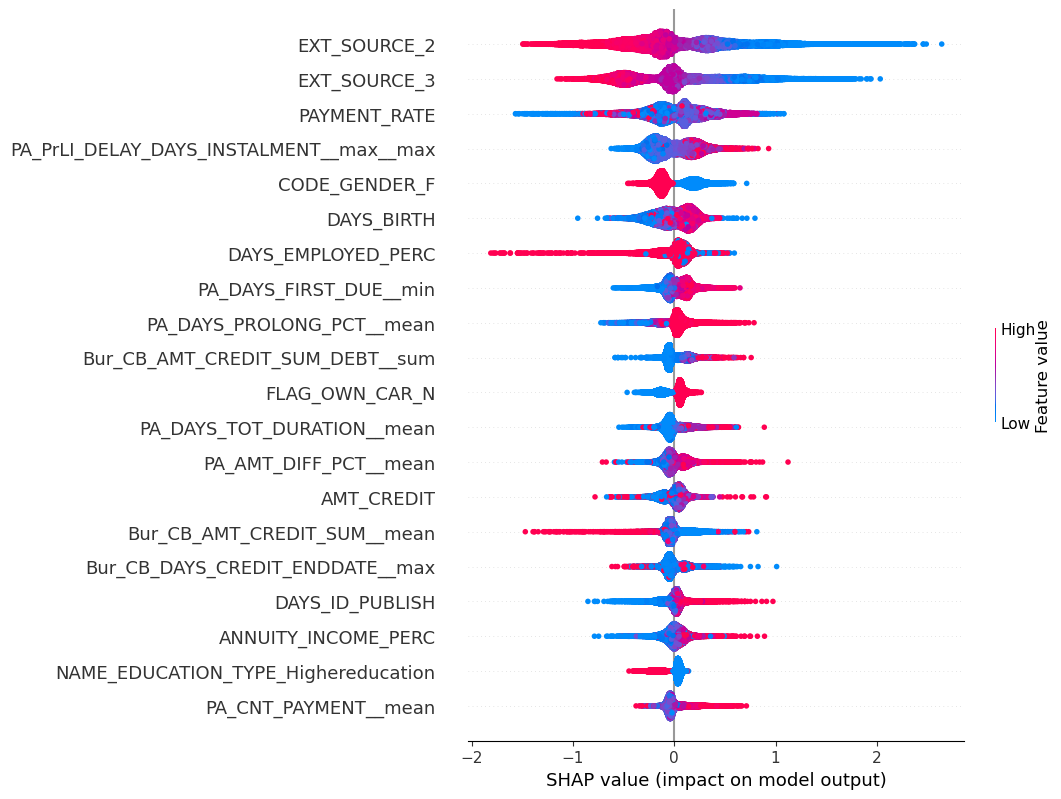

In [54]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

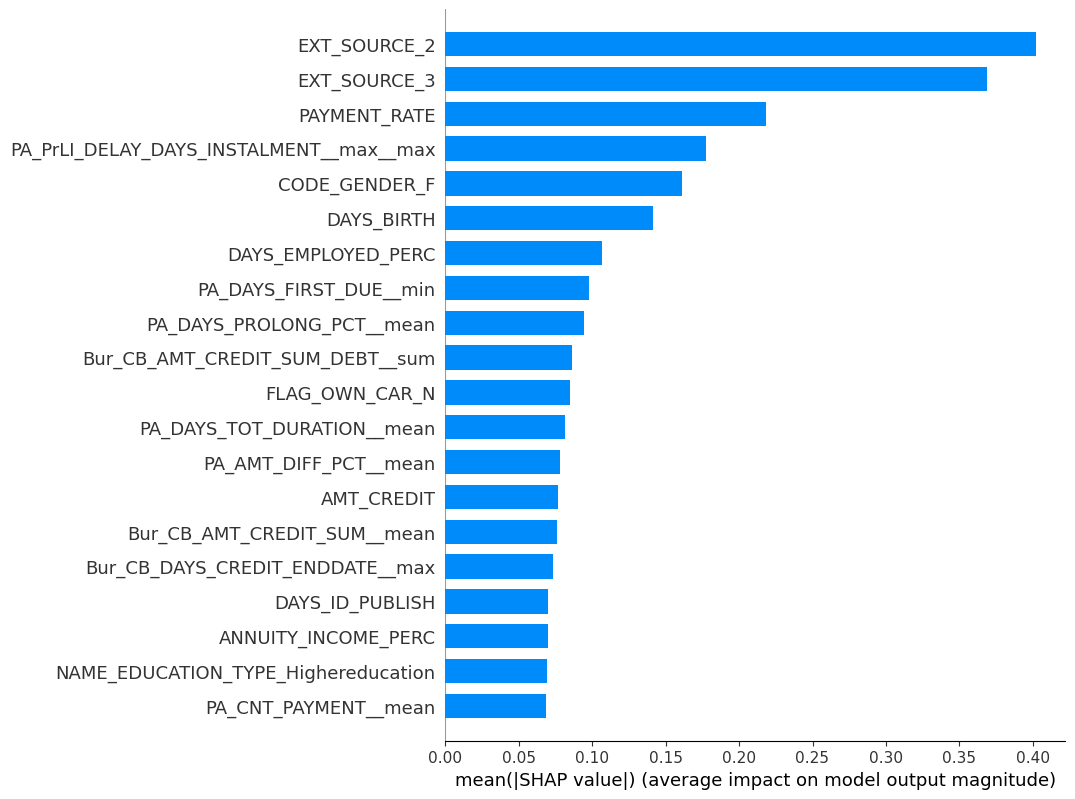

In [55]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns,plot_type='bar')

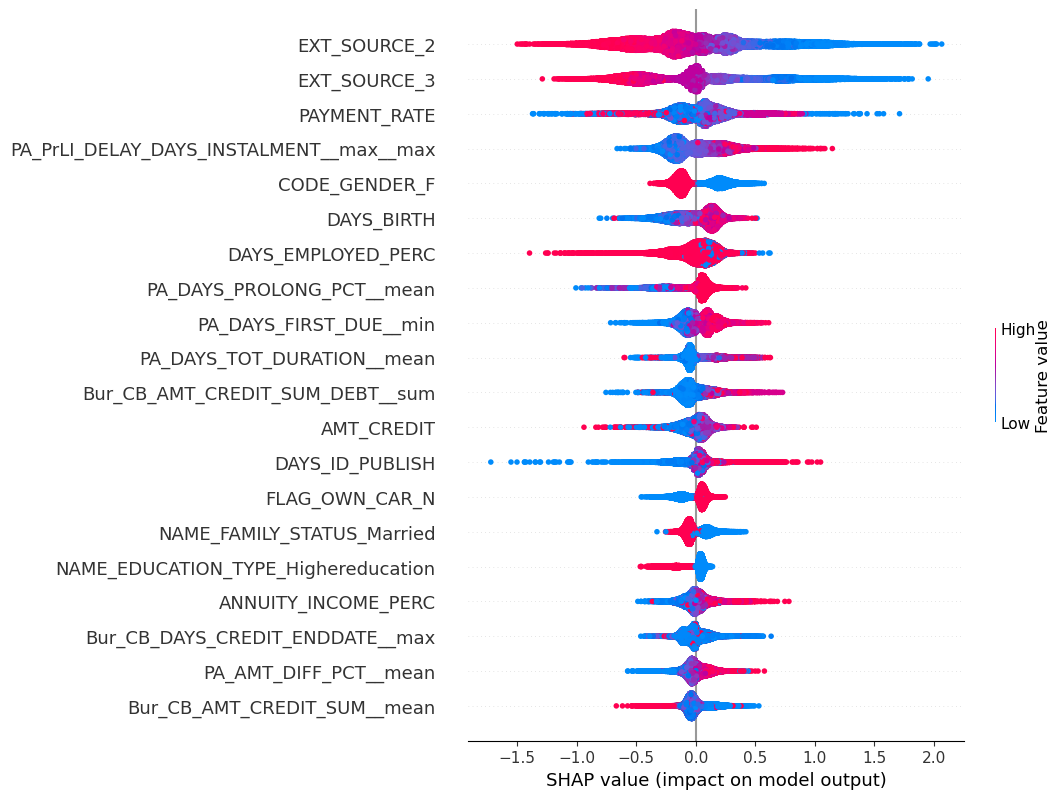

In [32]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns,plot_type='dot')

In [16]:
top_50_features_shap = X.columns[np.argsort(np.abs(shap_values).mean(0))][::-1][:50].to_list()
import pickle
with open('model/top_50_features_shap.pkl', 'wb') as fp:
    pickle.dump(top_50_features_shap, fp)

top_30_features_shap = X.columns[np.argsort(np.abs(shap_values).mean(0))][::-1][:30].to_list()
import pickle
with open('model/top_30_features_shap.pkl', 'wb') as fp:
    pickle.dump(top_30_features_shap, fp)

top_5_features_shap = X.columns[np.argsort(np.abs(shap_values).mean(0))][::-1][:5].to_list()
import pickle
with open('model/top_5_features_shap.pkl', 'wb') as fp:
    pickle.dump(top_5_features_shap, fp)

# with open('model/top_features_shap.pkl', 'rb') as fp:
#     top_features_shap = pickle.load(fp)
# top_features_shap.append('TARGET')
# top_features_shap

In [60]:
for feature in top_5_features_shap:
    print (feature,X[feature].min(),X[feature].max())

EXT_SOURCE_2 5.002108762101576e-06 0.8549996664047012
EXT_SOURCE_3 0.0005272652387098 0.8960095494948396
PAYMENT_RATE 0.022077235772357724 0.12442776735459662
PA_PrLI_DELAY_DAYS_INSTALMENT__max__max -101.0 2502.0
CODE_GENDER_F 0 1


## LGBM, Top 5 Features

In [41]:
top_5_features_shap

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'PAYMENT_RATE',
 'PA_PrLI_DELAY_DAYS_INSTALMENT__max__max',
 'CODE_GENDER_F']

In [40]:
X,y = get_Xy_sample_df(df,10000,0.5)
X = X[top_5_features_shap]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1234)

model = LGBMClassifier()
params = {'n_estimators': [100],
            'learning_rate':[0.1],
            'num_leaves':[34],
            'colsample_bytree':[0.9497036],
            'subsample':[0.8715623],
            'max_depth':[5],
            'reg_alpha':[0.041545473],
            'reg_lambda':[0.0735294],
            'min_split_gain':[0.0222415],
            'min_child_weight':[39.3259775]}

model = LGBMClassifier()
model_name = 'LGB_10k_Undersampled_BestParams_Top5Features'
run_model(X_train, X_test, y_train, y_test, model, model_name, params, 3)

RUNNING LGB_10k_Undersampled_BestParams_Top5Features
AUC Score: 0.68
              precision    recall  f1-score   support

           0       0.68      0.68      0.68      1000
           1       0.68      0.68      0.68      1000

    accuracy                           0.68      2000
   macro avg       0.68      0.68      0.68      2000
weighted avg       0.68      0.68      0.68      2000



## LGBM, Top 50 Features

In [345]:
X,y = get_Xy_sample_df(df,10000,0.5)
X = X[top_50_features_shap]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1234)

model = LGBMClassifier()
params = {'n_estimators': [100],
            'learning_rate':[0.1],
            'num_leaves':[34],
            'colsample_bytree':[0.9497036],
            'subsample':[0.8715623],
            'max_depth':[5],
            'reg_alpha':[0.041545473],
            'reg_lambda':[0.0735294],
            'min_split_gain':[0.0222415],
            'min_child_weight':[39.3259775]}

model = LGBMClassifier()
model_name = 'LGB_10k_Undersampled_BestParams_Top50Features'
run_model(X_train, X_test, y_train, y_test, model, model_name, params, 3)

RUNNING LGB_10k_Undersampled_BestParams_Top50Features
AUC Score: 0.687
              precision    recall  f1-score   support

           0       0.69      0.69      0.69      1000
           1       0.69      0.69      0.69      1000

    accuracy                           0.69      2000
   macro avg       0.69      0.69      0.69      2000
weighted avg       0.69      0.69      0.69      2000



## LGBM, Top 30 Features

In [346]:
X,y = get_Xy_sample_df(df,10000,0.5)
X = X[top_30_features_shap]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1234)

model = LGBMClassifier()
params = {'n_estimators': [100],
            'learning_rate':[0.1],
            'num_leaves':[34],
            'colsample_bytree':[0.9497036],
            'subsample':[0.8715623],
            'max_depth':[5],
            'reg_alpha':[0.041545473],
            'reg_lambda':[0.0735294],
            'min_split_gain':[0.0222415],
            'min_child_weight':[39.3259775]}

model = LGBMClassifier()
model_name = 'LGB_10k_Undersampled_BestParams_Top30Features'
run_model(X_train, X_test, y_train, y_test, model, model_name, params, 3)

RUNNING LGB_10k_Undersampled_BestParams_Top30Features
AUC Score: 0.705
              precision    recall  f1-score   support

           0       0.70      0.71      0.71      1000
           1       0.71      0.70      0.70      1000

    accuracy                           0.70      2000
   macro avg       0.71      0.70      0.70      2000
weighted avg       0.71      0.70      0.70      2000



In [347]:
show_results_basic()

,classifier,auc_score,best_score,fit_time,predict_time
1,LGB_10k_Undersampled_BestParams_Top30Features,0.705,0.756667,0.146922,0.003984
0,LGB_10k_Undersampled_BestParams_Top50Features,0.687,0.749240,0.205687,0.003989


## LGBM, Top 30 Features, ALL DATA

In [348]:
X,y = get_Xy_full(df)
X = X[top_30_features_shap]
num_class_1 = y.value_counts().to_list()[1]
X,y = get_Xy_sample_df(df,num_class_1*2,0.5)
X = X[top_30_features_shap]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1234)

model = LGBMClassifier()
params = {'n_estimators': [100],
            'learning_rate':[0.1],
            'num_leaves':[34],
            'colsample_bytree':[0.9497036],
            'subsample':[0.8715623],
            'max_depth':[5],
            'reg_alpha':[0.041545473],
            'reg_lambda':[0.0735294],
            'min_split_gain':[0.0222415],
            'min_child_weight':[39.3259775]}

model = LGBMClassifier()
model_name = 'LGB_10k_Undersampled_BestParams_Top30Features_ALLDATA'
run_model(X_train, X_test, y_train, y_test, model, model_name, params, 3)


RUNNING LGB_10k_Undersampled_BestParams_Top30Features_ALLDATA
AUC Score: 0.6945619335347433
              precision    recall  f1-score   support

           0       0.69      0.70      0.70      4965
           1       0.70      0.69      0.69      4965

    accuracy                           0.69      9930
   macro avg       0.69      0.69      0.69      9930
weighted avg       0.69      0.69      0.69      9930



In [349]:
show_results_basic()

,classifier,auc_score,best_score,fit_time,predict_time
1,LGB_10k_Undersampled_BestParams_Top30Features,0.705000,0.756667,0.146922,0.003984
2,LGB_10k_Undersampled_BestParams_Top30Features_...,0.694562,0.764536,0.509499,0.003990
0,LGB_10k_Undersampled_BestParams_Top50Features,0.687000,0.749240,0.205687,0.003989


# test a random sample with predict_proba lgbm

In [32]:
# load the model
# best_LGB_10k_Undersampled_BestParams_Top30Features_ALLDATA.pkl
model = joblib.load('model/best_LGB_10k_Undersampled_BestParams.pkl')

In [36]:
df.TARGET

SK_ID_CURR
100002    1
100003    0
100004    0
100006    0
100007    0
         ..
456251    0
456252    0
456253    0
456254    1
456255    0
Name: TARGET, Length: 307511, dtype: int64

In [39]:
# model is already fitted, get a random row from df
client = df.sample(n=1)
default = client.TARGET.values[0]
client = client.drop(columns=['TARGET'])
#client = client[top_30_features_shap]
print (client.index[0])
predprob = model.predict_proba(client)
print (predprob)
print (default)

348495
[[0.91887091 0.08112909]]
0


likely to default
- SK_ID_CURR:149624       default%:0.8102946
- SK_ID_CURR:330723       default%:0.83809922
- SK_ID_CURR:103236       default%:0.82804941

likely to not default
- SK_ID_CURR:221485       default%:0.11694268
- SK_ID_CURR:262634       default%:0.09147053
- SK_ID_CURR:280661       default%:0.18863612

undecided
- SK_ID_CURR:192895       default%:0.550512
- SK_ID_CURR:447080       default%:0.5297946
- SK_ID_CURR:112025       default%:0.49463249


# CONCLUSION:

LGBM seems to be the best model for this data, with undersampling.

The difference between ALL features and top 30 features is 0.705000 to 0.692548, and 0.756667 to 0.766420

So I can use the model best_LGB_10k_Undersampled_BestParams_Top30Features_ALLDATA

They are comparable for this excercise

For the API, therefore, I can consider either:
- using all features and letting the user choose from a list of customers, but the data might not be editable
- having 30 fields of free data, being able to be edited by the user



In [1]:
# TEST LOAD MODEL MAKE A PREDICTION FROM 5 PARAMS

In [ ]:
model = 